<a href="https://www.kaggle.com/code/merajhesh/loan-default-prediction?scriptVersionId=206726190" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [58]:
import numpy as np # linear algebra
import scipy.stats as ss
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy as spy
import sklearn.preprocessing as sp
import sklearn.compose as sc

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

pd.option_context('mode.use_inf_as_na', True)


/kaggle/input/loan-default-dataset/Loan_Default.csv


In [2]:
data = pd.read_csv('/kaggle/input/loan-default-dataset/Loan_Default.csv')
data.head()

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0


In [3]:
data.dtypes

ID                             int64
year                           int64
loan_limit                    object
Gender                        object
approv_in_adv                 object
loan_type                     object
loan_purpose                  object
Credit_Worthiness             object
open_credit                   object
business_or_commercial        object
loan_amount                    int64
rate_of_interest             float64
Interest_rate_spread         float64
Upfront_charges              float64
term                         float64
Neg_ammortization             object
interest_only                 object
lump_sum_payment              object
property_value               float64
construction_type             object
occupancy_type                object
Secured_by                    object
total_units                   object
income                       float64
credit_type                   object
Credit_Score                   int64
co-applicant_credit_type      object
a

Before we proceed with outlier detection and in order to make the investigation simpler, as a rule of thumb we will throw out those samples for which 15% of features have a missing values. This not only makes the analysis easier, it is also rational because a sample which is "contaminated" by so many missing values is not rather worthy of imputation. 

In [4]:
l = math.floor(len(data.columns)/5)
print(l)
print(' # Samples that will be deleted: ' + str((data.isna().sum(axis = 1) >= l).sum()))
df = data[data.isna().sum(axis = 1) < l]
df = df.reset_index(drop = True)
df.head()

6
 # Samples that will be deleted: 15163


,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
2,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
3,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0
4,24895,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,EXP,864,EXP,35-44,not_inst,70.089286,North,direct,0,40.0


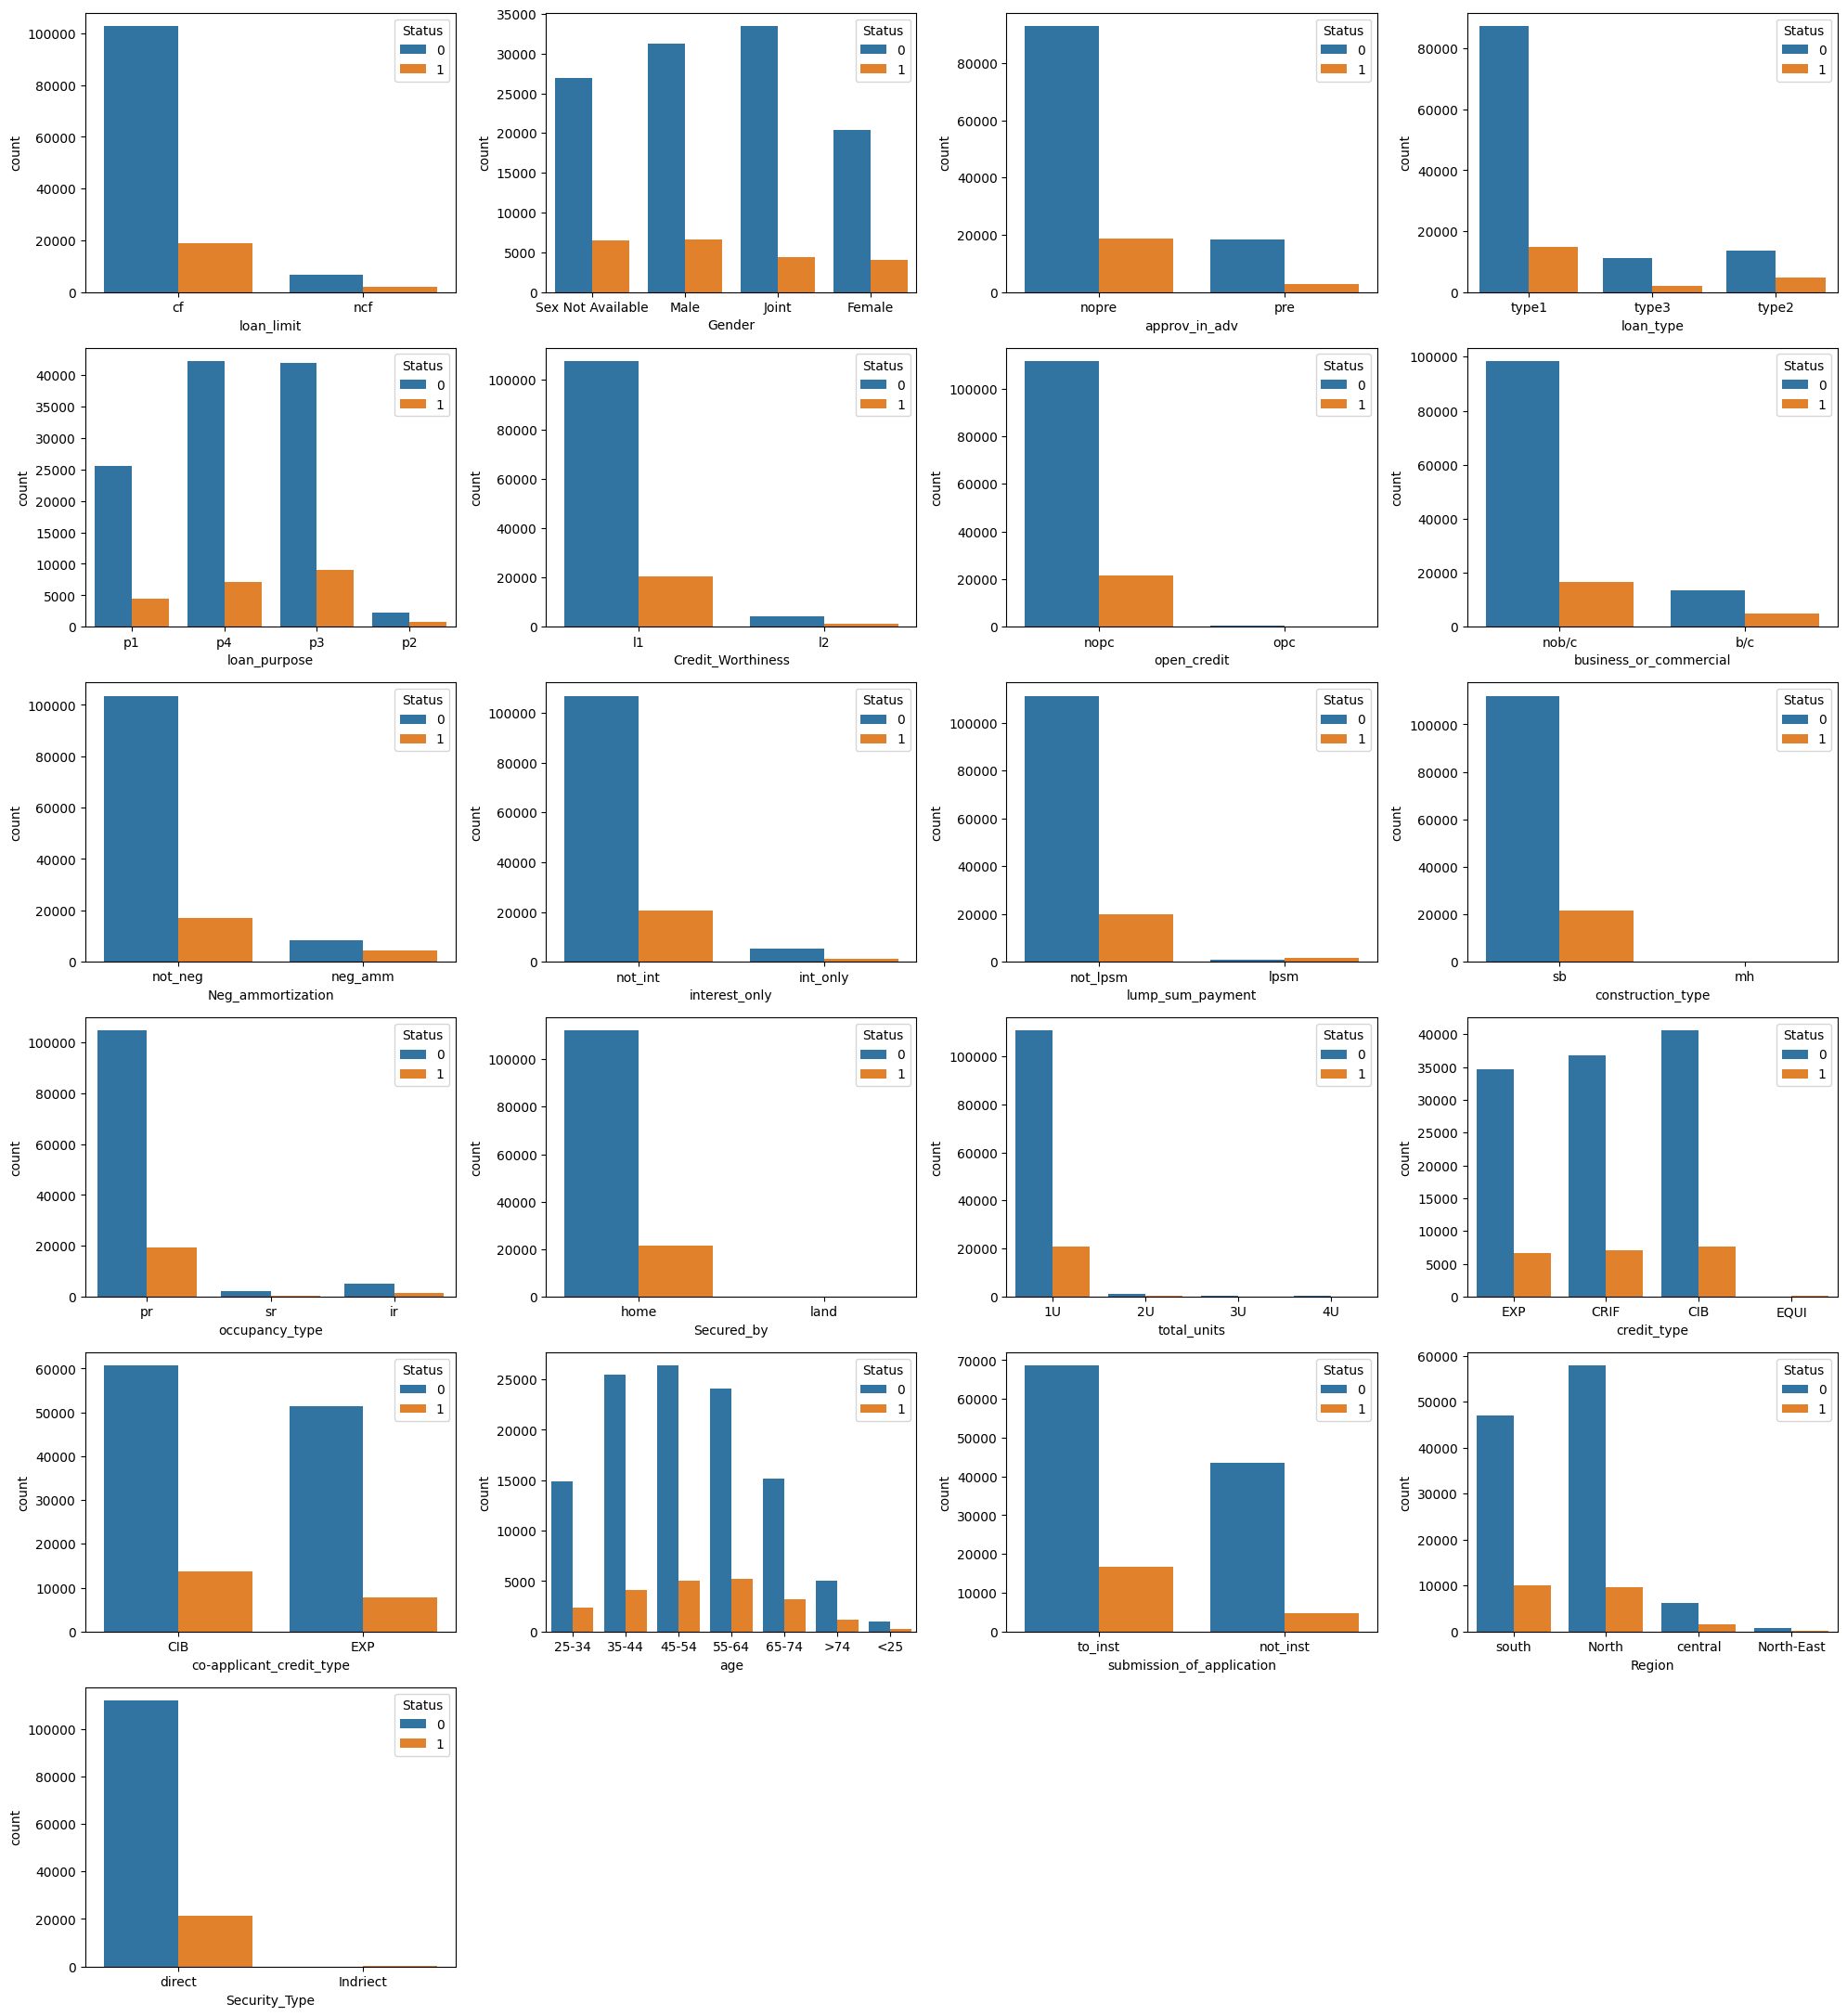

In [5]:
# count plots of categorical variables 
df_obj = df.select_dtypes(include = 'object')
df_obj_status = df_obj.join(df['Status'])

plt.figure(figsize=(20,25))
for i, col in enumerate(df_obj):
    plt.tight_layout()
    plt.subplot(7,4,i+1)
    sns.countplot(data = df_obj_status, x = col, hue='Status')

In [6]:
# log transformation
df_log_transformed = df.copy()
df_log_transformed = df_log_transformed[(df_log_transformed['income'] != 0) & (df_log_transformed['income'].isna() == False)]
df_log_transformed.loc[:,'income'] = np.log10(df_log_transformed.loc[:,'income'])
df_log_transformed['loan_amount'] = df_log_transformed['loan_amount'].astype(np.float64)
df_log_transformed.loc[:,'loan_amount'] = np.log10(df_log_transformed.loc[:,'loan_amount'] + 1)
df_log_transformed.loc[:,'property_value'] = np.log10(df_log_transformed.loc[:,'property_value'] + 1)
df_log_transformed.loc[:,'Upfront_charges'] = np.log10(df_log_transformed.loc[:,'Upfront_charges'] + 1)
df_log_transformed = df_log_transformed[df_log_transformed['LTV'] <= 100]
df_log_transformed.replace([np.inf, -np.inf], 0, inplace=True)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

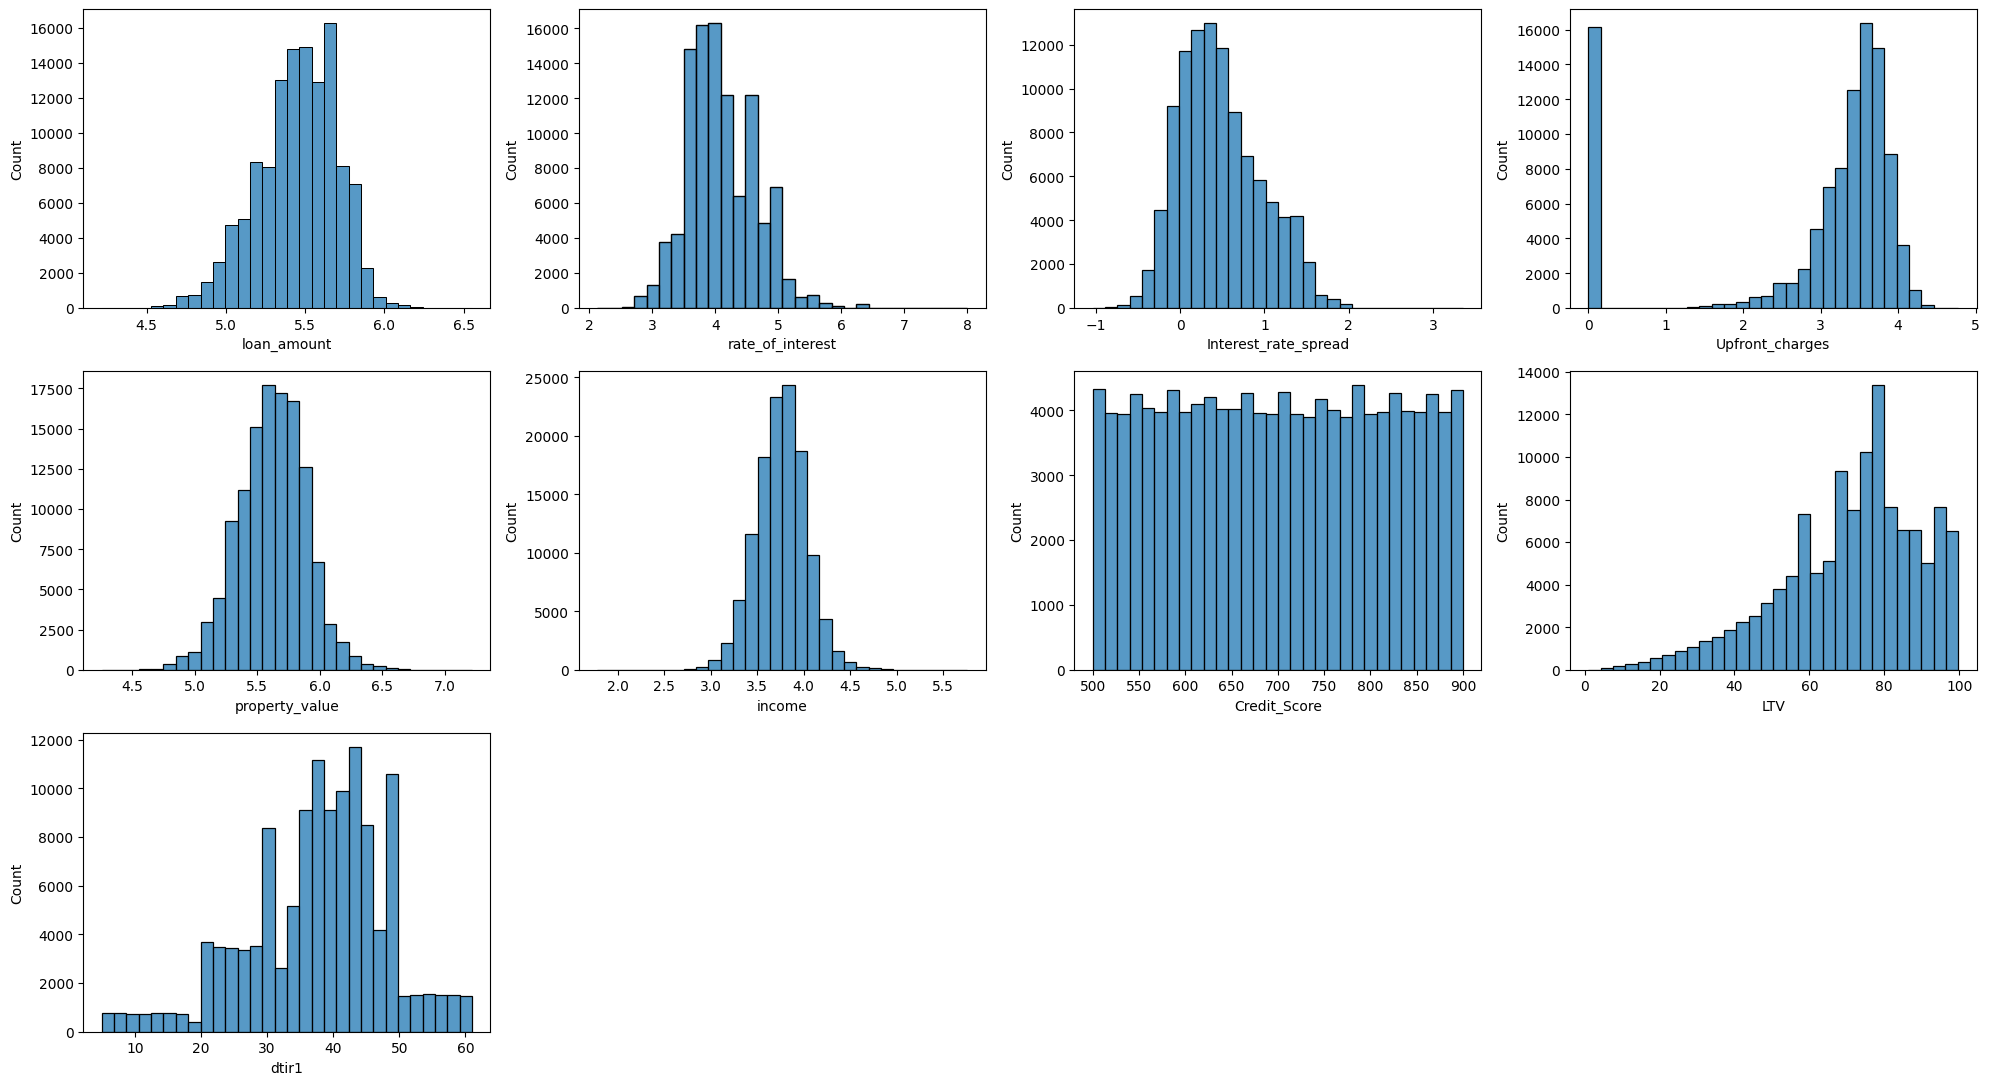

In [7]:
#  histograms of numerical variables
pd.option_context('mode.use_inf_as_na', True)
df_num = df_log_transformed.select_dtypes(exclude = 'object')
df_sub_num = df_num.drop(columns = ['ID', 'year', 'term', 'Status'])
#'LTV', 'income', 'property_value', 'Upfront_charges', 'rate_of_interest', 'Interest_rate_spread'
plt.figure(figsize=(20,25))
for i, col in enumerate(df_sub_num):
    if col != 'Status':
        plt.tight_layout()
        plt.subplot(7,4,i+1)
        sns.histplot(data = df_sub_num, x = col, bins = 30)

# Outliers
Here is how an outlier is defined according to Barnett and Lewis (19844: s "an observation (or subset of observations) which appears to be inconsistent with the remainder of that set of data". We can view outliers from two point of views. First, by looking at each feature individually. In this case, an outlier is identified as a value which is not consistent with the rest of the observations for a specific feature. We can use methods like "modified zscore" and "IQR method" to identify these outliers. Second, by looking at the dependency between features, but in particular between the features and the target variable. A good approach would be to use with grouping of the data using pandas "crosstab". Then apply the methods above or calculate leverage or other distances such as Mahalanobis distance to identify outliers. 

In general, droping entries because they have been identified outliers by these methods should be done with cautious. It is always better to identify inconsitancy in data by applying EDA. 

### Loan to Value ratio (LTVr)

LTVr is the amount of loan divided by the value of the asset which is being purchased. LTVr cannot  be more than 100 %. 

count    133505.000000
mean         72.741030
std          39.976153
min           0.967478
25%          60.474860
50%          75.135870
75%          86.184211
max        7831.250000
Name: LTV, dtype: float64


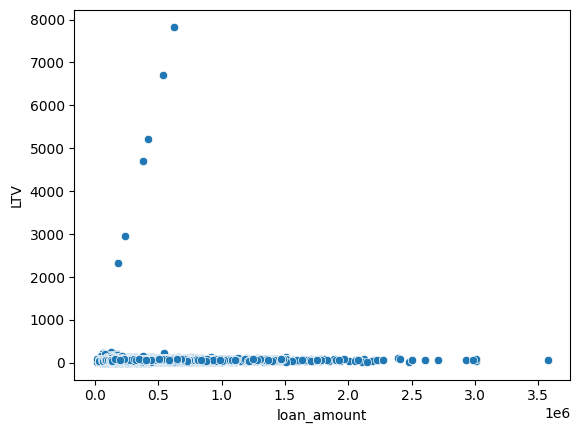

In [8]:
print(df['LTV'].describe())
sns.scatterplot(df, y = 'LTV', x = 'loan_amount')
plt.show()

Calculating asset values by loan amounts multiplied by LTVr clearly shows that these values are most probably entered by mistake. Additionally, we find a lot of entries with missing "rate of interest" among the entries with LTVr greater than 100, which is suspecious! We can assume that these values are entered by mistake and correct them by dividing by 100. However, this is too risky and would be more wise to delete these entries. Just in case:

https://en.wikipedia.org/wiki/Loan-to-value_ratio#:~:text=Higher%20LTV%20ratios%20are%20primarily,100%25%20are%20called%20underwater%20mortgages.

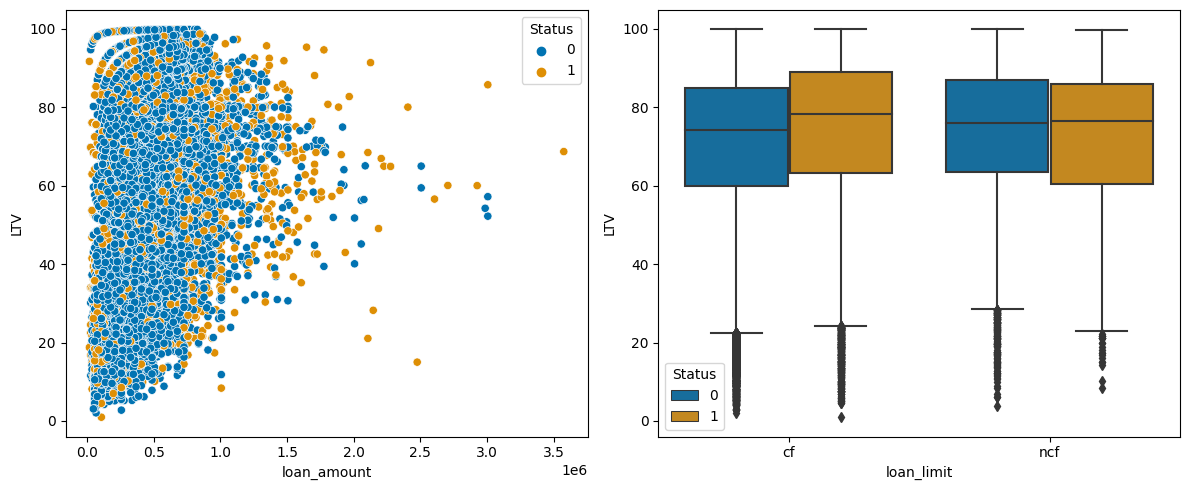

In [9]:
df_out = df.copy()
df_out = df_out[df_out['LTV'] <= 100]
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(df_out, y = 'LTV', x = 'loan_amount', hue = 'Status', palette = 'colorblind', ax = ax[0])
sns.boxplot(data = df_out, x = 'loan_limit', y = 'LTV', hue = 'Status', palette = 'colorblind', ax = ax[1])
plt.tight_layout()
plt.show()

### Rate of interest
There is also an unusal sample with zero rate of interest. Since interest rate spread is also an outlier for this sample we will assume that the sample is contaminated and it is better to drop it. 

In [10]:
df_out = df_out[df_out['rate_of_interest'] != 0]
df_out

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
2,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
3,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0
4,24895,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,EXP,864,EXP,35-44,not_inst,70.089286,North,direct,0,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133502,173555,2019,cf,Sex Not Available,nopre,type1,p3,l1,nopc,nob/c,...,CIB,659,EXP,55-64,to_inst,71.792763,south,direct,0,48.0
133503,173556,2019,cf,Male,nopre,type1,p1,l1,nopc,nob/c,...,CIB,569,CIB,25-34,not_inst,74.428934,south,direct,0,15.0
133504,173557,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,CIB,702,EXP,45-54,not_inst,61.332418,North,direct,0,49.0
133505,173558,2019,cf,Female,nopre,type1,p4,l1,nopc,nob/c,...,EXP,737,EXP,55-64,to_inst,70.683453,North,direct,0,29.0


### Income

Dept to income ratio is non-zero for all samples which do not have missing values. However, income is zero in many cases. This cannot be true! Instead considering these as outliers, we think they can be considered as missing values. We will discuss this case in the next chapter. 

Additionally, some incomes are really low for those who are getting a loan for secondery or investment residency (occypancy type of sr and ir). 

In [11]:
df_tmp = df_out[df_out['income'] > 0] 
pd.crosstab(df_tmp['occupancy_type'], df_tmp['Status'], values = df_tmp['income'], aggfunc = 'median').round(2)

Status,0,1
occupancy_type,,
ir,8700.0,6540.0
pr,5880.0,4500.0
sr,10080.0,7890.0


In [12]:
df_tmp = df_out[df_out['income'] > 1500] 
pd.crosstab(df_tmp['occupancy_type'], df_tmp['Status'], values = df_tmp['income'], aggfunc = 'median').round(2)

Status,0,1
occupancy_type,,
ir,8820.0,6780.0
pr,5880.0,4740.0
sr,10080.0,7980.0


However, by comparing two cases where one only considers incomes above 1500 (a salary which one earns almost with minimum wage per hour), there is no concrete evidance that there is systematic sampling error behind these observations.

### Modified Zscore



We will derive the modified zscores for the numeric features just to get a sense of the extent of outliers recognized by this method. Later during modeling we will remove such entries to see if removing such entries it has "reasonable" impact on the performance of the models. By reasonable we mean if test accuracy is not impacted or overfitting does not occur. 

In [13]:
df_num_num = df.copy()
df_num_num = df_num_num.select_dtypes(exclude = 'object')
df_num_num = df_num_num.drop(['ID', 'year', 'Status', 'Upfront_charges'], axis = 1)
df_num_num = df_num_num[df_num_num['income'] > 0]

In [14]:
def modified_zscore (data):
    med = data.apply(lambda x: abs(x - x.median()))
    mad = med.apply(lambda x: x.median())
    mzscore = pd.DataFrame()
    for i in range(1,len(mad)):
        if mad.iloc[i] != 0:
            mz = abs(0.6745 *(data.iloc[:,i] - data.iloc[:,i].median())/mad.iloc[i]) > 3.5
            mzscore = pd.concat([mzscore.reset_index(drop=True), mz], axis = 1)
    return mzscore

mzscores = modified_zscore(df_num_num)
mzscores.sum()

rate_of_interest         287
Interest_rate_spread      12
property_value          3782
income                  4127
Credit_Score               0
LTV                      339
dtir1                      0
dtype: object

### Mahalanobis Distance

We will investigate this distance after dealing with missing data.

In [15]:
def MahalanobisDistance(data): 
    y_mu = data - np.mean(data) 
    cov = np.cov(data.values.T) 
    #inv_covmat = np.linalg.inv(cov) 
    #left = np.dot(y_mu, inv_covmat) 
    #mahal = np.dot(left, y_mu.T) 
    return cov#mahal.diagonal()
#df_num_log = np.log10(df_num_num + 1)
#MahalD = MahalanobisDistance(df_num_log)
#MahalD

# Treating Missing Data

## Estimation

In this approach we estimate missing information by using each feature individually.

In [16]:
print("#Samples: " + str(len(df)))
df_out.isna().sum()

#Samples: 133507


ID                               0
year                             0
loan_limit                    2923
Gender                           0
approv_in_adv                  799
loan_type                        0
loan_purpose                   106
Credit_Worthiness                0
open_credit                      0
business_or_commercial           0
loan_amount                      0
rate_of_interest             20163
Interest_rate_spread         20307
Upfront_charges              23300
term                            29
Neg_ammortization              112
interest_only                    0
lump_sum_payment                 0
property_value                   0
construction_type                0
occupancy_type                   0
Secured_by                       0
total_units                      0
income                        8775
credit_type                      0
Credit_Score                     0
co-applicant_credit_type         0
age                            144
submission_of_applic

In [17]:
df_out = df_out.reset_index(drop = True)
df_missing = df_out.copy()
income_est = pd.crosstab(df_out['Status'], df_out['loan_purpose'], values = df_out['income'], aggfunc = 'median')
income_est

loan_purpose,p1,p2,p3,p4
Status,,,,
0,6240.0,4800.0,5160.0,6960.0
1,4740.0,3360.0,4200.0,5400.0


**Income** is log-normally distributed (histrogram suffices for us as evidance; however tests of normality can also be applied). To handle missing data, we can either impute using the mean of the log-transformed values or the median of the original income values. Additionally, we can improve the imputation by incorporating loan status and loan purpose as grouping variables. This is because income seems to differ noticably between these groups. In particular, we replace missing income values with the corresponding estimator (either the mean of the log-transformed values or the median of the original values) derived from the subset of data within each loan status group. This approach ensures that the imputation reflects differences across loan statuses. Note that incomes with zero values are also considered as missing. 

In [18]:
def numerical_missing (dff, est, col, vals = None):
    dat = dff.copy()
    where_income_missing = np.where((dat[col].isna()) | (dat[col] == 0))[0]
    y = 0
    for row in where_income_missing:
        x = dat.iloc[row,:]
        if vals is None:
            y = est
        elif len(vals) == 1:
            y = est.loc[x[vals[0]]]
        elif len(vals) == 2:
            y = est.loc[x[vals[0]],x[vals[1]]]
        dat.loc[row,col] = y
    return dat


In [19]:
df_cleaned_0 = numerical_missing(df_missing, income_est, 'income', np.array(['Status', 'loan_purpose']))
df_cleaned_0.head()

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
2,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
3,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0
4,24895,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,EXP,864,EXP,35-44,not_inst,70.089286,North,direct,0,40.0


loan_amount             0.435843
rate_of_interest       -0.036748
Interest_rate_spread   -0.136621
term                   -0.054326
property_value          0.409585
income                  1.000000
Credit_Score            0.000994
LTV                    -0.062389
dtir1                  -0.273364
Name: income, dtype: float64


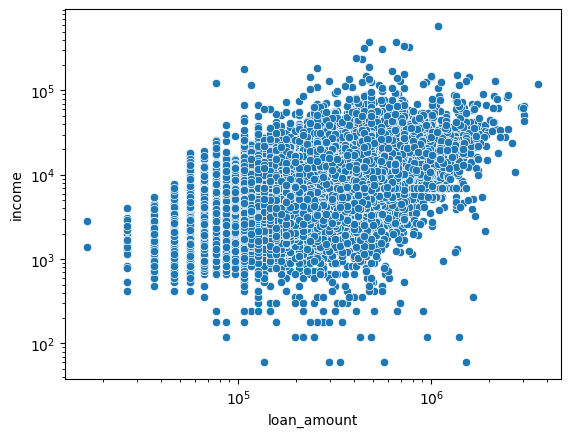

In [20]:
# income
print(df_cleaned_0.select_dtypes(exclude = 'object').drop(['ID', 'year', 'Status', 'Upfront_charges'], axis = 1).corr()['income'])
sns.scatterplot(df_cleaned_0, y = 'income', x = 'loan_amount')
plt.xscale('log')
plt.yscale('log')
plt.show()

For a series of categorical features for which missing data is present, we can use either knn or binomial/multinomial distributions to impute the missing data. Among those are:
- age
- submission of application
- approved in advance (approv_in_adv)
- loan purpose
- Negative Ammortization
- loan limit

In [21]:
print(df_cleaned_0['age'].value_counts()) #multinomial
print('  ')
print(df_cleaned_0['submission_of_application'].value_counts()) #binomial
print('  ')
print(df_cleaned_0['approv_in_adv'].value_counts()) #binomial
print('  ')
print(df_cleaned_0['loan_purpose'].value_counts()) #multinomial
print('  ')
print(df_cleaned_0['Neg_ammortization'].value_counts()) #binomial
print('  ')
df['loan_limit'].value_counts() # binomial

age
45-54    31032
35-44    29244
55-64    28935
65-74    18124
25-34    16918
>74       6150
<25       1160
Name: count, dtype: int64
  
submission_of_application
to_inst     83856
not_inst    47707
Name: count, dtype: int64
  
approv_in_adv
nopre    110150
pre       20758
Name: count, dtype: int64
  
loan_purpose
p3    50570
p4    48813
p1    29303
p2     2915
Name: count, dtype: int64
  
Neg_ammortization
not_neg    119280
neg_amm     12315
Name: count, dtype: int64
  


loan_limit
cf     121819
ncf      8732
Name: count, dtype: int64

In [22]:
def categorical_missing(aldata, col, p = None, vals = None):
    dff = aldata.copy()
    if vals is None:
        vals = dff[col].dropna().unique()
    if p is None:
        p = dff[col].value_counts()/dff[col].value_counts().sum()
    where_missing = np.where(dff[col].isna())[0]
    n = len(where_missing)
    mult = np.random.multinomial(1, p, n)
    k = 0
    t = []
    for i in mult:
        k = k + 1
        t.append(vals[i == 1][0])
    dff.loc[where_missing, col] = t
    return dff

Similar to "age", "**loan term**" can be placed in brackets and treated as a categorical variable. There is not enough evidance of high correlation with other features. Hence, we will replace missing terms by using multinomial distribution where probabilities are estimated as the weights of each term interval.

In [23]:
df_cleaned_1 = categorical_missing(df_cleaned_0, 'age')
df_cleaned_1 = categorical_missing(df_cleaned_1, 'submission_of_application')
df_cleaned_1 = categorical_missing(df_cleaned_1, 'approv_in_adv')
df_cleaned_1 = categorical_missing(df_cleaned_1, 'loan_purpose')
df_cleaned_1 = categorical_missing(df_cleaned_1, 'loan_limit')
df_cleaned_1 = categorical_missing(df_cleaned_1, 'Neg_ammortization')

**Term** of a loan can be also an important factor in default. Term has few missing values. It can be seen that more than 80% of the loans are issued for 360 months or 30 years, and more than 95% for 15 years or more. The 30 years term is so dominant in the data that makes replacing the missing values a chance. Later in feature engineering we would bin this feature in few intervals, namely, <180, 180-240, 240-360. 

In [24]:
df_tmp = df_cleaned_1[df_cleaned_1['term'].isna() == False]
print(pd.crosstab(df_tmp['Status'], df_tmp['loan_purpose'], values = df_tmp['term'], aggfunc = 'mean'))
print(df_tmp['term'].value_counts())

loan_purpose          p1          p2          p3          p4
Status                                                      
0             351.839081  324.246463  328.297618  332.219241
1             347.005753  322.924138  333.994695  331.334323
term
360.0    107938
180.0     11607
240.0      5253
324.0      2515
300.0      2107
120.0       455
144.0       240
348.0       239
336.0       191
312.0       171
96.0        167
156.0       159
216.0       103
276.0        85
288.0        82
132.0        80
168.0        72
228.0        63
204.0        53
264.0        41
108.0        31
192.0        16
252.0         8
280.0         1
322.0         1
Name: count, dtype: int64


In [25]:
N = (df_tmp['term'].isna() == False).sum()
p1 = (df_tmp['term'] <= 180 ).sum()/N
p2 = ((df_tmp['term'] <=240 ) & (df_tmp['term'] > 180 )).sum()/N
p3 = (df_tmp['term'] > 240).sum()/N
pp = np.array([p1,p2,p3])
v = np.array([180,240,360])
df_cleaned_2 = categorical_missing(df_cleaned_1, 'term', p = pp, vals = v)

**Debt to Income Ratio (DTIR)** is another important feature which contains relatively large amount missing data. It incorporates debt, an important variable which can be the leading cause of default. Therefore, it is important to impute the missing data for this random variable. DTIR has a skewed distribution. Additionally, it does not indicate difference in distribution and first moments when marginal distributions conditioned on different categorical variables are taken into account. However, there is slight difference if we consider default and non-default cases. Hence, the median of DTIR for each default and non-default cases can be a good estimator for imputing missing DTIR. 

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


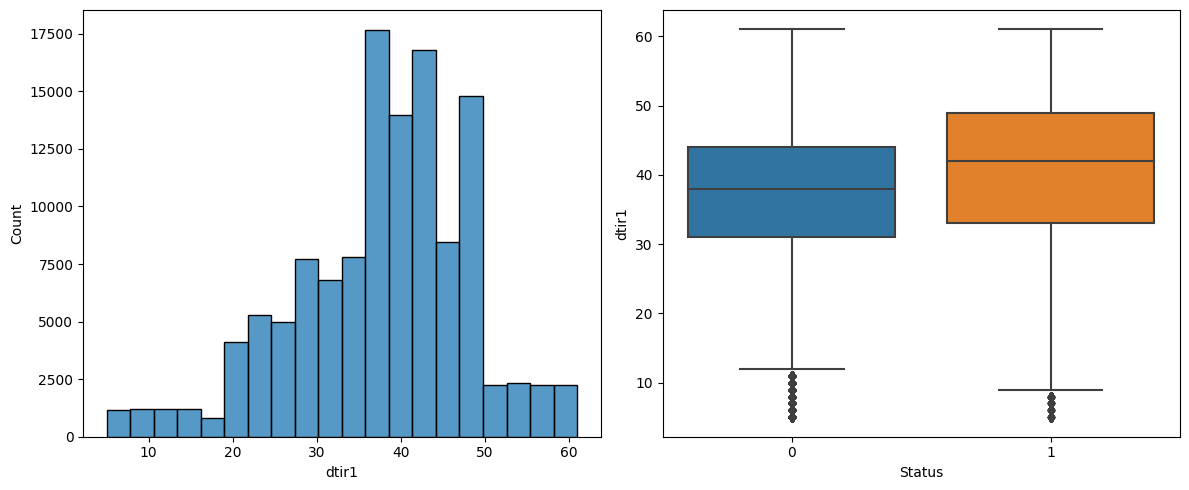

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df_out, x = 'dtir1', bins = 20, ax = ax[0])
sns.boxplot(data = df_log_transformed, x = 'Status', y = 'dtir1', ax = ax[1])
plt.tight_layout()
plt.show()

In [27]:
# dtir1
ditr_est = df_cleaned_2.groupby(['Status'])['dtir1'].median()
df_cleaned_3 = numerical_missing(df_cleaned_2, ditr_est, 'dtir1', np.array(['Status']))
df_cleaned_3.head()

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
2,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
3,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0
4,24895,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,EXP,864,EXP,35-44,not_inst,70.089286,North,direct,0,40.0


**Upfront Charges** seems to be dependent on loan type and loan purpose.  However, there are a lot of loans issued with zero upfront charges. For these cases, the fee is probably included in the loan amount itself. Banks usually do that, however, then the interest rates wil be calculated higher. We also keep in mind that the upfront charges are usually calculated as a percentage of loan amount. Hence, we do not know two things about missing data and we would like to estimate those. First, if the upfront charges were included in the loan. For these loans, the upfront charges would be zero. Second, what percentage of loan is considered as an upfront fee if this fee is not zero. We will do as follows: 1) we flip a coin for the fee to be included in the loan amount, i.e., fee being zero or not, 2) if not zero, then we calculated the fee as the loan amount multiplied by the mean percentage of non-zero upfront charges relative to loan amount. 

In [28]:
df_tmp = df_cleaned_3.copy()
where_missing = np.where(df_tmp['Upfront_charges'].isna())[0]
lul = len(where_missing)
pul = len(df_tmp[df_tmp['Upfront_charges'] == 0])/len(df_tmp[df_tmp['Upfront_charges'].isna() == False])
pul = np.array([pul, 1- pul])
u = (df_tmp[df_tmp['Upfront_charges'] > 0]['Upfront_charges'])
l = (df_tmp[df_tmp['Upfront_charges'] > 0]['loan_amount'])
ul = u*100/l
mul = ul.mean()
vul = np.array([0,mul])
mull = np.random.multinomial(1, pul, lul)
k = 0
t = []
for i in mull:
    k = k + 1
    t.append(vul[i == 1][0])
df_tmp.loc[where_missing, 'Upfront_charges'] = t
df_cleaned_4 = df_tmp.copy().reset_index()

**Rate of Interest** and **Interest rate spread** look pretty much normal. We can impute the missing values by using the average of each column. 

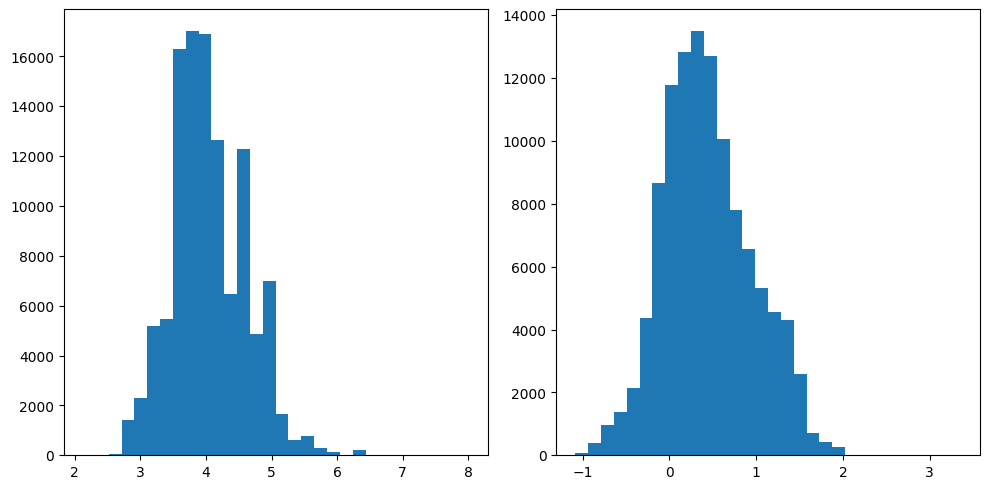

,rate_of_interest,Interest_rate_spread
count,111544.000000,111400.000000
mean,4.046697,0.443484
std,0.561194,0.512789
min,2.125000,-1.084100
25%,3.625000,0.077400
50%,3.990000,0.392000
75%,4.375000,0.777800
max,8.000000,3.357000


In [29]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(df_cleaned_4['rate_of_interest'], bins = 30)
ax[1].hist(df_cleaned_4['Interest_rate_spread'], bins = 30)
plt.tight_layout()
plt.show()
df_cleaned_4[['rate_of_interest', 'Interest_rate_spread']].describe()

In [30]:
df_cleaned_5 = df_cleaned_4.copy()
df_cleaned_5['rate_of_interest'] = df_cleaned_5['rate_of_interest'].fillna(df_cleaned_5['rate_of_interest'].mean())
df_cleaned_5['Interest_rate_spread'] = df_cleaned_5['Interest_rate_spread'].fillna(df_cleaned_5['Interest_rate_spread'].mean())

## Regression/Classification

Alternatively, we can estimate missing values by treating the feature as a dependent variable and using othe features where missing data is absent as independent variable. 

For example, given the linear relationship between loan amount and income, simple linear regression can be applied to predict and impute the missing values of income. This approach leverages the predictive power of related variables to generate more accurate estimates for the missing data.

# Feature Engineering


**Terms** of mortgages are usually 15, 20, or 30 years. This can be easily seen from the data that terms are dominated by these few values. Therefore, binning terms and converting it to categorical variable seems to be a reasonable idea rather than using it as numerical variable. While there are different appraoches to binning (either simple statistical appraoches as equal width/frequency binning, or ML appraoches like k-means clustering), based on our knowledge of the data it seems to be reasonable to bin the the terms in the intervals named above. 

In [49]:
df_engineered_0 = df_cleaned_5.copy()
df_engineered_0['term'] = pd.cut(df_engineered_0['term'], bins = [0, 180, 240, 360], labels = ['short', 'medium', 'long'])

The **upfront charges** feature is a complicated one. There are many 0 values and many fees that are realy small relative to loan amount. There are also many values as large as 20000 or above (actually the max is around 60000). As we discussed above, the upfront fees are usually calculated as a percentage of loan amount. Additionally, in many cases the fee can be included in the loan amount. Considering these facts we proceed as follows: 1) we create another feature which encodes the upfront charges to be zero or not (in fact we treat really small values like 300 or less also as zero). 2) we transform the upfront charges to percentages of loan amount. These transformations have the advantage that they add information to the data where it is actually missing, i.e., the zero fees.

In [50]:
df_engineered_1 = df_engineered_0.copy()
df_engineered_1['Upfront_charges_y/n'] = np.where(df_engineered_1['Upfront_charges'] < 300, 0, 1)
df_engineered_1['Upfront_charges'] = df_engineered_1['Upfront_charges']*100/df_engineered_1['loan_amount']

We will also log Transformation to **income, property value, loan amount, and Credit Score**. The reason is that their distributions are right-skewed. Transformation helps with fairly representing the difference between values, in particular, reducing the impact of outliers. 

In [51]:
df_engineered_2 = df_engineered_1.copy()
df_engineered_2['income'] = np.log10(df_engineered_2['income'])
df_engineered_2['property_value'] = np.log10(df_engineered_2['property_value'])
df_engineered_2['loan_amount'] = np.log10(df_engineered_2['loan_amount'])

Of note, we could still apply scaling, however, we find it not necessary at this point as most of the numerical do not differ significantly in range of values. Later we can also investigate the model performances if numerical featrues are scaled. 

Before we apply encoding to categorical variables, we will drop the following columns: **ID, Year, LTV**. LTV will be dropped because its information is already contained in loan amount and property value.

In [52]:
df_engineered_3 = df_engineered_2.drop(['ID', 'year', 'index'], axis = 1)

We can apply traget encoding to **age and Region** because of their high cardinality. The most suitable encoding for **term and total units** is ordinal labling. This is because higher terms and higher number of units is highly correlated with the property value and the loan amount, and consequently with the default ratio. The rest of categorical variables can be encoded using dummy method, i.e., using N-1 features to represent N labels/categories.

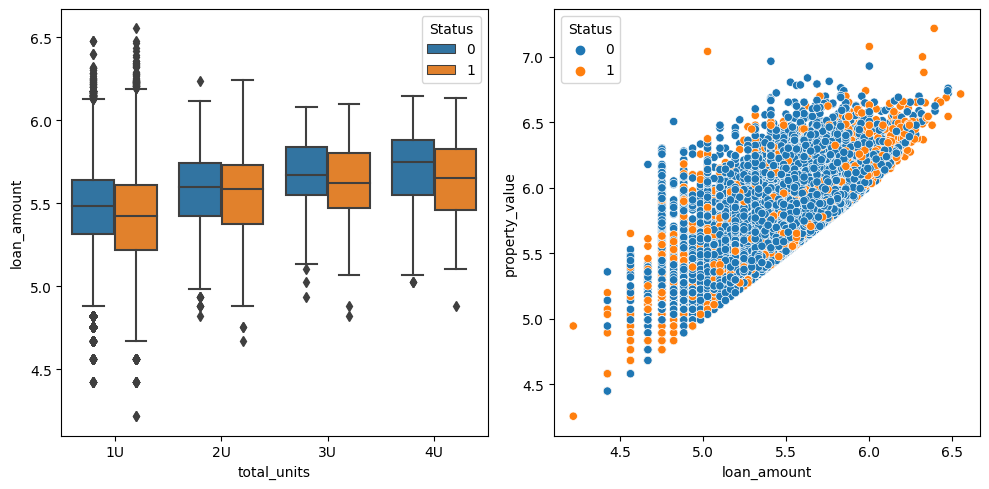

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.boxplot(df_engineered_3, x = 'total_units', y = 'loan_amount', hue = 'Status', ax = ax[0])
sns.scatterplot(df_engineered_3, x = 'loan_amount', y = 'property_value', hue = 'Status', ax = ax[1])
plt.tight_layout()
plt.show()

In [65]:
df_engineered_4 = df_engineered_3.copy()
# target
target_mean_age = df_engineered_4.groupby('age')['Status'].mean()
df_engineered_4['age'] = df_engineered_4['age'].map(target_mean_age)
target_mean_region = df_engineered_4.groupby('Region')['Status'].mean()
df_engineered_4['Region'] = df_engineered_4['Region'].map(target_mean_region)
#ordinal
df_engineered_4['age'] = df_engineered_4['age'].astype('category')
df_engineered_4['total_units'] = df_engineered_4['total_units'].astype('category')
df_engineered_4['Region'] = df_engineered_4['Region'].astype('category')
Oencoder = sp.OrdinalEncoder()
df_engineered_4[['term', 'total_units']] = Oencoder.fit_transform(df_engineered_4[['term', 'total_units']]) + 1
# dummy

## # Specify the categorical columns to be one-hot encoded
cardinal_cols = df_engineered_4.select_dtypes(include = 'object').columns

## # Define the ColumnTransformer with OneHotEncoder
## # drop='first' will drop the first category to avoid multicollinearity
column_transforms = sc.ColumnTransformer(transformers = [('onehot', sp.OneHotEncoder(drop='first'), cardinal_cols)], remainder='passthrough')

## # Apply the transformation
df_tmp = column_transforms.fit_transform(df_engineered_4[cardinal_cols])

## # Convert the result to a DataFrame for easier readability
## # Extract feature names after encoding
onehot_feature_names = column_transforms.named_transformers_['onehot'].get_feature_names_out(cardinal_cols)
df_tmp = pd.DataFrame(df_tmp, columns = onehot_feature_names)

## # drop original columns
df_engineered_4 = df_engineered_4.drop(cardinal_cols, axis = 1)

## # concat dataframes
df_engineered_4 = pd.concat([df_engineered_4, df_tmp], axis=1)

In [66]:
df_engineered_4

,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,property_value,total_units,income,Credit_Score,age,...,construction_type_sb,occupancy_type_pr,occupancy_type_sr,Secured_by_land,credit_type_CRIF,credit_type_EQUI,credit_type_EXP,co-applicant_credit_type_EXP,submission_of_application_to_inst,Security_Type_direct
0,5.066326,4.046697,0.443484,0.000000,1.0,5.071882,1.0,3.240549,758,0.129955,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
1,5.609061,4.560000,0.200000,0.146371,1.0,5.705864,1.0,3.976808,834,0.133297,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
2,5.659441,4.250000,0.681000,0.000335,1.0,5.818226,1.0,4.074816,587,0.155248,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,5.842921,4.000000,0.304200,0.000000,1.0,5.879669,1.0,4.018700,602,0.129955,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,5.849112,3.990000,0.152300,0.052371,1.0,6.003461,1.0,4.003461,864,0.133297,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131702,5.639984,3.125000,0.257100,2.281787,3.0,5.783904,1.0,3.895423,659,0.170489,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
131703,5.768268,5.190000,0.854400,0.000000,1.0,5.896526,4.0,3.853698,569,0.129955,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
131704,5.649821,3.125000,0.081600,0.274723,3.0,5.862131,1.0,3.838849,702,0.155248,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
131705,5.293363,3.500000,0.582400,2.200168,3.0,5.444045,1.0,3.853698,737,0.170489,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0


In [37]:
def normality_test (feature):
    a = spy.stats.normaltest(feature)
    print(a)
    b = spy.stats.anderson(feature)
    print(b)
    n = np.random.normal(feature.mean(), feature.std(), len(feature))
    c = spy.stats.kstest(feature, n)
    print(c)

# Modeling

1. KNN
2. ridge/lasso
3. Gradient Bossting
4. NN


# Validation